# CNN을 이용한 고양이/강아지 예측

## 0. 라이브러리

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

## 1. 데이터

### 1) 다운로드/로드

* torchvision.transforms
>* Compose(): 데이터 전처리 모음 (일괄 처리)
>* ToTensor(): 이미지의 픽셀을 0~1 사이의 값으로 변환하여 Tensor로 반환

In [31]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trans

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [32]:
ROOT = 'dataset/cnn'
dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=trans) # 각 folder의 이름을 class 이름으로 인식

print(type(dataset))
print(dataset)

<class 'torchvision.datasets.folder.ImageFolder'>
Dataset ImageFolder
    Number of datapoints: 4
    Root location: dataset/cnn
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


### 2) 탐색

In [33]:
dataset.classes # cat: 0, dog: 1

['cat', 'dog']

In [34]:
print(type(dataset[0]))
print(dataset[0]) # tensor([[[...]]], 0) -> tensor(): 전처리된 이미지, 0: cat (class)

<class 'tuple'>
(tensor([[[-0.9843, -0.9843, -0.9922,  ..., -0.9529, -0.9529, -0.9529],
         [-0.9843, -0.9843, -0.9922,  ..., -0.9529, -0.9529, -0.9529],
         [-0.9843, -0.9843, -0.9922,  ..., -0.9529, -0.9529, -0.9529],
         ...,
         [-0.4353, -0.4353, -0.4902,  ..., -0.9216, -0.9373, -0.9608],
         [-0.4196, -0.4118, -0.4902,  ..., -0.9059, -0.9216, -0.9451],
         [-0.4353, -0.4196, -0.4980,  ..., -0.8824, -0.8902, -0.9137]],

        [[-0.9843, -0.9843, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9843, -0.9843, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9843, -0.9843, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.6157, -0.6157, -0.6549,  ..., -0.9529, -0.9686, -0.9922],
         [-0.6000, -0.5922, -0.6549,  ..., -0.9451, -0.9529, -0.9765],
         [-0.6157, -0.5843, -0.6627,  ..., -0.9216, -0.9294, -0.9451]],

        [[-0.9843, -0.9843, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9843, -0.9843, 

In [35]:
print(type(dataset[2]))
print(dataset[2]) # tensor([[[...]]], 1) -> tensor(): 전처리된 이미지, 1: dog (class)

<class 'tuple'>
(tensor([[[ 0.8588,  0.8824,  0.9137,  ...,  0.8039,  0.7961,  0.7804],
         [ 0.8745,  0.8902,  0.9059,  ...,  0.7961,  0.7961,  0.7961],
         [ 0.8824,  0.8902,  0.8980,  ...,  0.7882,  0.7961,  0.8039],
         ...,
         [-0.6392, -0.5922, -0.5686,  ..., -0.5686, -0.5608, -0.5451],
         [-0.5686, -0.5765, -0.6078,  ..., -0.5451, -0.5137, -0.4980],
         [-0.6078, -0.5922, -0.6000,  ..., -0.5137, -0.4745, -0.4275]],

        [[ 0.8353,  0.8588,  0.8902,  ...,  0.7961,  0.7882,  0.7725],
         [ 0.8510,  0.8667,  0.8824,  ...,  0.7882,  0.7882,  0.7882],
         [ 0.8588,  0.8667,  0.8745,  ...,  0.7804,  0.7882,  0.7961],
         ...,
         [-0.7882, -0.7412, -0.7255,  ..., -0.7333, -0.7255, -0.7255],
         [-0.7176, -0.7255, -0.7569,  ..., -0.7255, -0.7176, -0.7020],
         [-0.7569, -0.7412, -0.7490,  ..., -0.7176, -0.6784, -0.6471]],

        [[ 0.7020,  0.7255,  0.7569,  ...,  0.5608,  0.5529,  0.5373],
         [ 0.7176,  0.7333, 

In [36]:
dataset[0][0].shape # [channel 개수, 세로 픽셀 수, 가로 픽셀 수]

torch.Size([3, 1920, 1837])

### 3) 전처리

In [37]:
# 전처리 세팅
transform = transforms.Compose(
    [transforms.RandomRotation(30), # 랜덤 방향(시계/반시계)으로 30도 회전 -> 검은색 배경이 생기는데, 그 검은색 배경이 -1
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                        # (0.5, 0.5, 0.5) -> RGB 각 채널마다 평균을 0.5로 만들어라
                                          # (0.5, 0.5, 0.5) -> RGB 각 채널마다 표준편차를 0.5로 만들어라
)

In [38]:
# 전처리 적용
transform(dataset[0][0])

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


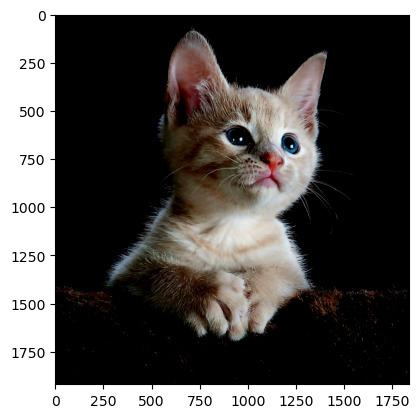

In [39]:
# 이미지 출력
image = dataset[0][0].permute(1, 2, 0) # pytorch의 permute = numpy의 transpose와 동일한 역할 (tensor의 인덱스 위치 변경)
# original의 shape : (3, 1920, 1837) -> (채널, 세로, 가로)
# image의 shpae : (1837,1920,  3) -> (가로, 세로, 채널)

plt.imshow(image) # plt에서 이미지를 출력하려면 input 데이터의 위치를 바꿔줘야 함
plt.show()

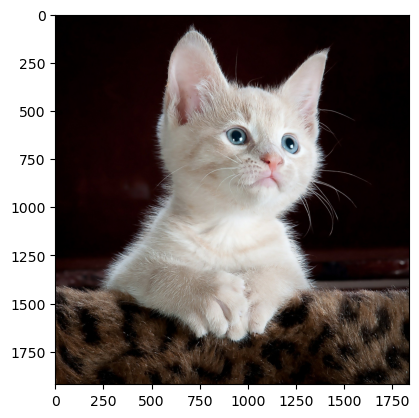

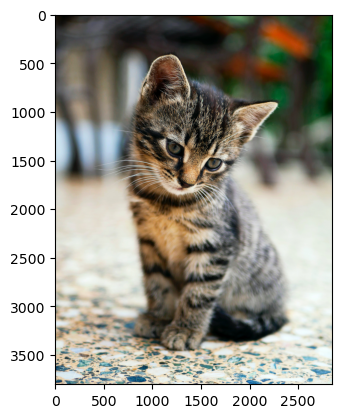

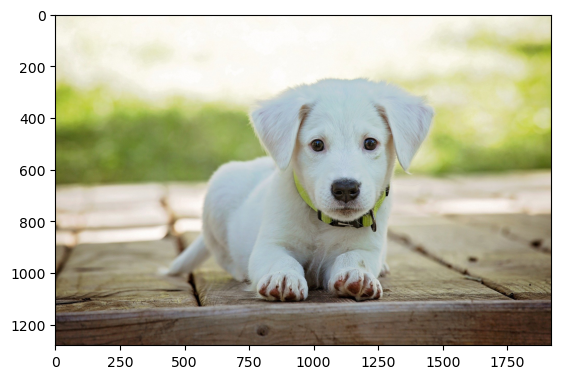

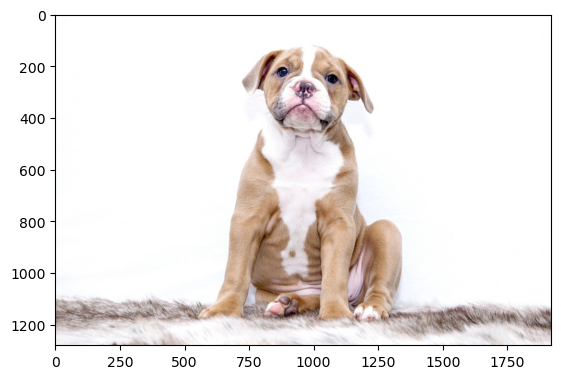

In [40]:
# 1. 원본 이미지
trans = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=trans)

for i in range(4):
  image = dataset[i][0].permute(1, 2, 0)

  plt.imshow(image)
  plt.show()

torch.Size([3, 224, 224])


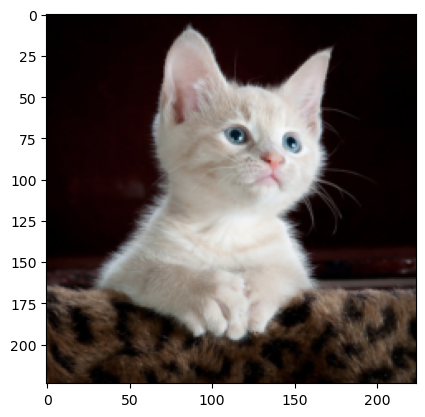

torch.Size([3, 224, 224])


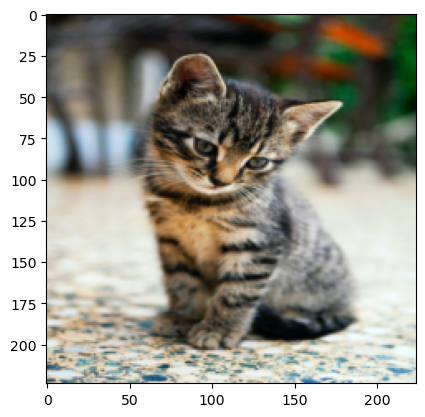

torch.Size([3, 224, 224])


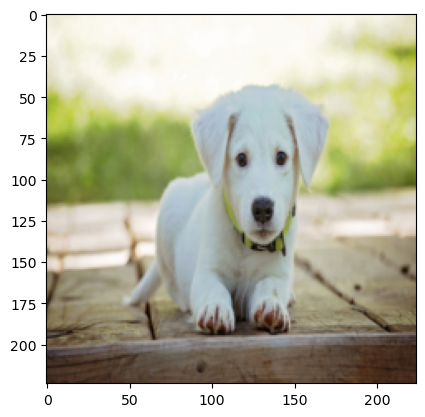

torch.Size([3, 224, 224])


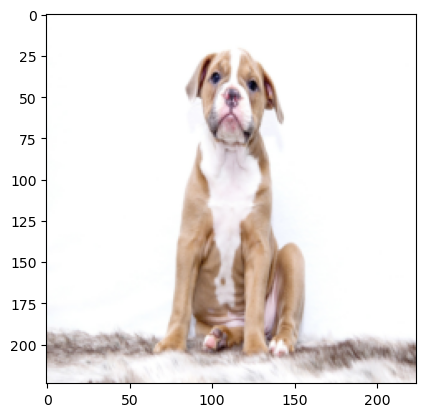

In [41]:
# 2. 크기 변경
trans = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]) # 224*224 -> ImageNet에서 제공하는 이미지 사이즈 (fine tuning에 유리하므로, 통상적으로 사용함)
dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=trans)

for i in range(4):
  print(dataset[i][0].shape)

  image = dataset[i][0].permute(1, 2, 0)

  plt.imshow(image)
  plt.show()

torch.Size([3, 224, 224])


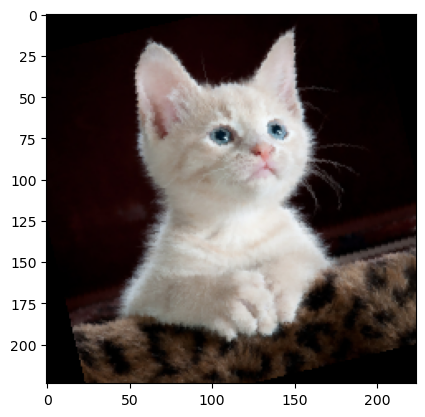

torch.Size([3, 224, 224])


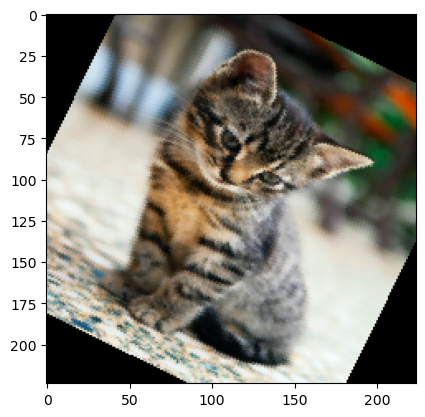

torch.Size([3, 224, 224])


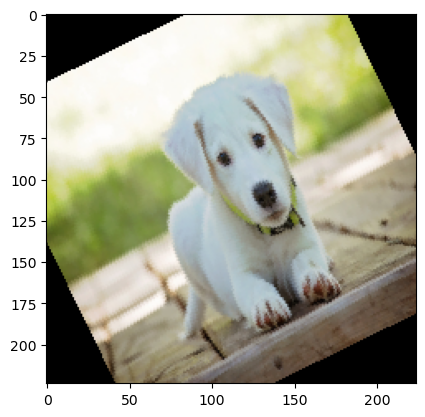

torch.Size([3, 224, 224])


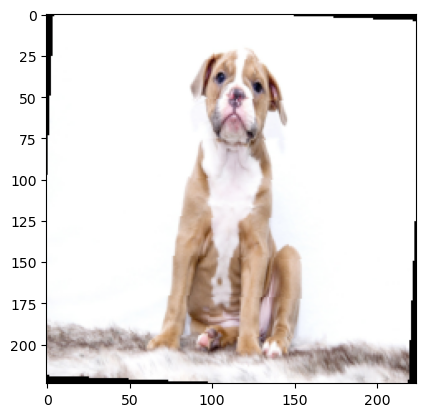

In [42]:
# 3. 크기 변경 + 랜덤 회전
trans = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(30), transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=trans)

for i in range(4):
  print(dataset[i][0].shape)

  image = dataset[i][0].permute(1, 2, 0)

  plt.imshow(image)
  plt.show()

torch.Size([3, 224, 224])


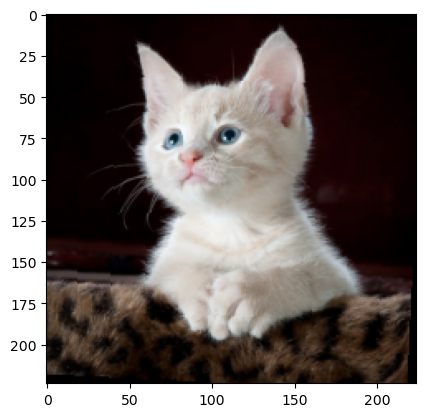

torch.Size([3, 224, 224])


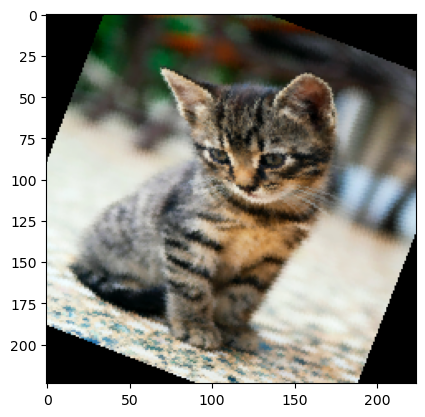

torch.Size([3, 224, 224])


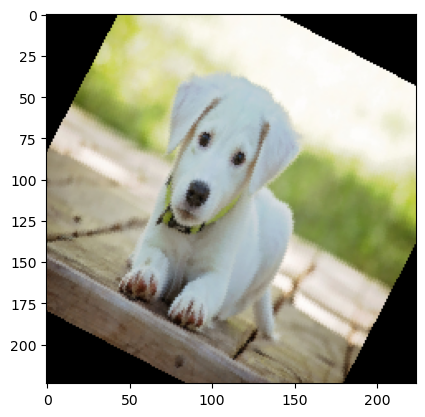

torch.Size([3, 224, 224])


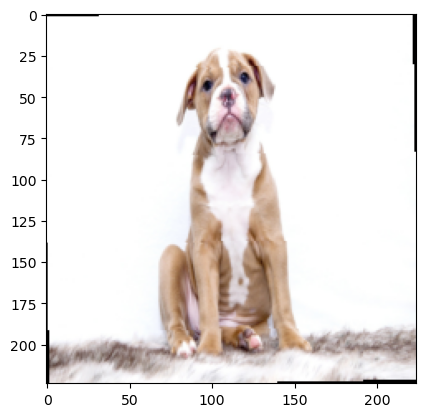

In [43]:
# 4. 크기 변경 + 랜덤 좌우대칭 + 랜덤 회전
trans = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(0.5), transforms.RandomRotation(30), transforms.ToTensor()]) # transforms.RandomHorizontalFlip(0.5) -> 50%의 확률로 좌우 반전
dataset = torchvision.datasets.ImageFolder(root=ROOT, transform=trans)

for i in range(4):
  print(dataset[i][0].shape)

  image = dataset[i][0].permute(1, 2, 0)

  plt.imshow(image)
  plt.show()

## 2. 모델링

### 1) CNN 모듈

In [44]:
# 첫 번째 이미지
data = dataset[0][0]
print('data shape:', data.shape)
data = data.unsqueeze(0) # 0번째 인덱스에 1차원 추가
print('unsqueezed data shape:', data.shape) # [mini batch, channel, height, width]

data shape: torch.Size([3, 224, 224])
unsqueezed data shape: torch.Size([1, 3, 224, 224])


#### Convolution

* Conv2d()

In [45]:
in_channel = 3 # RGB 컬러 이미지이므로 3개
out_channel = 5 # feature map 개수 = CNN filter 개수 (사용자 지정값)
kernel_size = 3 # local information (or filter) size

conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=1)
conv1

Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))

In [46]:
out = conv1(data)

print('data shape:', data.shape) # [1, 3, 224, 224]
print('conv1(data) shape:', out.shape) # [1, 5, 222, 222]

data shape: torch.Size([1, 3, 224, 224])
conv1(data) shape: torch.Size([1, 5, 222, 222])


#### Pooling

* MaxPool2d()

In [47]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)
pool

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [48]:
print('conv1(data) shape:', out.shape) # [1, 5, 222, 222]

out = pool(out)

print('pool(conv1(data)) shape:', out.shape) # [1, 5, 111, 111]

conv1(data) shape: torch.Size([1, 5, 222, 222])
pool(conv1(data)) shape: torch.Size([1, 5, 111, 111])


#### Convolution

* Conv2d

In [49]:
in_channel2 = out_channel
out_channel2 = 2

conv2 = nn.Conv2d(in_channel2, out_channel2, kernel_size=5, stride=3)
conv2

Conv2d(5, 2, kernel_size=(5, 5), stride=(3, 3))

In [50]:
print('pool(conv1(data)) shape:', out.shape) # [1, 5, 111, 111]

out = conv2(out)

print('conv2(pool(conv1(data))) shape:', out.shape) # [1, 2, 36, 36]

pool(conv1(data)) shape: torch.Size([1, 5, 111, 111])
conv2(pool(conv1(data))) shape: torch.Size([1, 2, 36, 36])


#### Pooling

* AdaptiveAvgPool2d()

In [51]:
out_size = 8

adaptive_pool = nn.AdaptiveAvgPool2d(out_size) # output의 가로, 세로 길이 설정
adaptive_pool

AdaptiveAvgPool2d(output_size=8)

In [52]:
print('conv2(pool(conv1(data))) shape:', out.shape) # [1, 2, 36, 36]

out = adaptive_pool(out) # flatten을 편하게 할 수 있음

print('adaptive_pool(conv2(pool(conv1(data)))) shape:', out.shape) # [1, 2, 8, 8]

conv2(pool(conv1(data))) shape: torch.Size([1, 2, 36, 36])
adaptive_pool(conv2(pool(conv1(data)))) shape: torch.Size([1, 2, 8, 8])


#### Fully Connection

* Linear()

In [53]:
num_classes = len(dataset.classes) # 2

fc = nn.Linear(out_channel2*out_size*out_size, num_classes)
fc

Linear(in_features=128, out_features=2, bias=True)

In [54]:
print('adaptive_pool(conv2(pool(conv1(data)))) shape:', out.shape) # [1, 2, 8, 8]

out = out.reshape(1, -1) # 3D-tensor -> 1D-vector

print('adaptive_pool(conv2(pool(conv1(data)))).reshape(1, -1) shape:', out.shape) # [1, 128]

adaptive_pool(conv2(pool(conv1(data)))) shape: torch.Size([1, 2, 8, 8])
adaptive_pool(conv2(pool(conv1(data)))).reshape(1, -1) shape: torch.Size([1, 128])


In [55]:
print('adaptive_pool(conv2(pool(conv1(data)))).reshape(1, -1) shape:', out.shape) # [1, 128]

out = fc(out)

print('fc(adaptive_pool(conv2(pool(conv1(data)))).reshape(1, -1)) shape:', out.shape) # [1, 2]

adaptive_pool(conv2(pool(conv1(data)))).reshape(1, -1) shape: torch.Size([1, 128])
fc(adaptive_pool(conv2(pool(conv1(data)))).reshape(1, -1)) shape: torch.Size([1, 2])


### 2) 전체 모델

In [56]:
class CNN(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential( # nn.Sequential() -> () 안에 있는 기능들을 순차적으로 진행하겠다.
                    nn.Conv2d(3, 5, kernel_size=3, stride=1),
                    nn.ReLU())
    self.pool =  nn.MaxPool2d(kernel_size=2, stride=2)
    self.layer2 = nn.Sequential(
                    nn.Conv2d(5, 2, kernel_size=5, stride=3),
                    nn.ReLU())
    self.adaptive_pool = nn.AdaptiveAvgPool2d(8)
    self.fc = nn.Linear(2*8*8, 2)

  def forward(self, x):
    out = self.layer1(x) # 3 channel -> 5 channel
    out = self.pool(out) # 5 channel -> 5 channel
    out = self.layer2(out) # 5 channel -> 2 channel
    out = self.adaptive_pool(out) # 2 channel -> 2 channel, shape=(2, 8, 8)
    out = out.reshape(out.shape[0], -1) # 3d tensor 데이터 -> 1d tensor(vector)로 변환
    out = self.fc(out) # vector(2592) -> vector(2)
    return out

In [57]:
model = CNN()

In [58]:
sample = dataset[0][0]
print('sample shape : {}'.format(sample.shape))

sample = sample.unsqueeze(0)
print('after add dim for batch : {}'.format(sample.shape))

sample shape : torch.Size([3, 224, 224])
after add dim for batch : torch.Size([1, 3, 224, 224])


In [ ]:
output = model(sample)
output

tensor([[ 0.0258, -0.1590]], grad_fn=<AddmmBackward0>)

In [ ]:
F.softmax(output, dim=-1) # 모델 예측 -> 0(cat)일 확률: 0.54, 1(dog)일 확률: 0.45

tensor([[0.5461, 0.4539]], grad_fn=<SoftmaxBackward0>)